# Approach 2 Investigation

In [1]:
import psycopg2 as pg
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Establish connection to postgres
conn = pg.connect(database='postgres',
                  user='postgres',
                  password='w207final',
                  host='35.185.225.167')

### Get the train/dev data from the database

#### Approach2: Training data is all regular season data (2003-2018)

In [3]:
approach2TrainingDataQuery = '''  SELECT * FROM prod."features" f WHERE (f."Season Type"='Regular') AND (f."Season" < 2019) ORDER BY "Season", "DayNum", "Team"  '''
df_approach2_training = pd.read_sql_query(approach2TrainingDataQuery, conn)

#### Approach2: Dev data is all tournament data (2003-2017)

In [4]:
approach2DevDataQuery = ''' SELECT * FROM prod."features" f WHERE (f."Season Type"='NCAA Tourney') AND (f."Season" > 2002) AND (f."Season" < 2018) order by "Season", "DayNum", "Team" '''
df_approach2_dev = pd.read_sql_query(approach2DevDataQuery, conn)

#### Approach2Combined: Training data is all regular season data (2003-2018) and the tournament games before 2014 (2003-2013)

In [5]:
approach2CombinedTrainingDataQuery = '''  SELECT * FROM prod."features" f WHERE (f."Season Type"='Regular') OR (f."Season" < 2014) ORDER BY "Season", "DayNum", "Team"  '''
df_approach2Combined_training = pd.read_sql_query(approach2CombinedTrainingDataQuery, conn)

#### Approach2Combined: Dev data is tournament data between 2014-2017

In [6]:
approach2CombinedDevDataQuery = ''' SELECT * FROM prod."features" f WHERE (f."Season Type"='NCAA Tourney') AND (f."Season" > 2013) AND (f."Season" < 2018) order by "Season", "DayNum", "Team" '''
df_approach2Combined_dev = pd.read_sql_query(approach2CombinedDevDataQuery, conn)

In [7]:
conn.close()

### Create Train and Dev Sets

In [8]:
target = 'Outcome'
features = ['TwoPointPct_Team', 'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team', 'DefensiveRebounds_Team', 'TwoPointPct_Opponent', 'ThreePointPct_Opponent', 'FreeThrowPct_Opponent', 'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'AvgRank', 'OpponentAvgRank', 'WinPct', 'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst', 'AvgNetPointsFor', 'OpponentAvgPointsFor', 'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'SeedDiff', 'TourWins', 'OpponentTourWins', 'TourWinsDiff']

In [9]:
X_train2 = df_approach2_training[features]
y_train2 = df_approach2_training[target]
X_dev2  = df_approach2_dev[features]
y_dev2  = df_approach2_dev[target]

In [10]:
X_train2_combined = df_approach2Combined_training[features]
y_train2_combined = df_approach2Combined_training[target]
X_dev2_combined  = df_approach2Combined_dev[features]
y_dev2_combined  = df_approach2Combined_dev[target]

#### Examine the number of NaNs (or Nones) in data from all regular season games

In [11]:
X_train2_counts_df = X_train2.count().to_frame().T
X_train2_nan_counts_df = X_train2.shape[0] - X_train2_counts_df

In [12]:
X_train2_nan_counts_df[['TwoPointPct_Team', 'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team', 'DefensiveRebounds_Team', 'TwoPointPct_Opponent', 'ThreePointPct_Opponent', 'FreeThrowPct_Opponent', 'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent']]

,TwoPointPct_Team,ThreePointPct_Team,FreeThrowPct_Team,OffensiveRebounds_Team,DefensiveRebounds_Team,TwoPointPct_Opponent,ThreePointPct_Opponent,FreeThrowPct_Opponent,OffensiveRebounds_Opponent,DefensiveRebounds_Opponent
0,5481,5481,5481,5481,5481,5481,5481,5481,5481,5481


In [13]:
X_train2_nan_counts_df[['AvgRank', 'OpponentAvgRank', 'WinPct', 'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst', 'AvgNetPointsFor', 'OpponentAvgPointsFor', 'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'SeedDiff', 'TourWins', 'OpponentTourWins', 'TourWinsDiff']]

,AvgRank,OpponentAvgRank,WinPct,OpponentWinPct,WinPctDiff,AvgPointsFor,AvgPointsAgainst,AvgNetPointsFor,OpponentAvgPointsFor,OpponentAvgPointsAgainst,OpponentAvgNetPointsFor,SeedDiff,TourWins,OpponentTourWins,TourWinsDiff
0,7884,7884,5481,5481,6704,5481,5481,5481,5481,5481,5481,164082,0,0,0


The following have 164082 'None': SeedDiff.  **We will ignore this column**

The following have 5481 NaNs: TwoPointPct_Team, ThreePointPct_Team, FreeThrowPct_Team, OffensiveRebounds_Team, DefensiveRebounds_Team, TwoPointPct_Opponent, ThreePointPct_Opponent, FreeThrowPct_Opponent, OffensiveRebounds_Opponent, DefensiveRebounds_Opponent, WinPct	OpponentWinPct, AvgPointsFor, AvgPointsAgainst, AvgNetPointsFor, OpponentAvgPointsFor, OpponentAvgPointsAgainst, OpponentAvgNetPointsFor

In [14]:
print 'Which is: {0:.2f} % of the data. Since this is a small percentage, they can be removed.'.format(float(X_train2_nan_counts_df['TwoPointPct_Team'])/X_train2.shape[0]*100)

Which is: 3.34 % of the data. Since this is a small percentage, they can be removed.


The following have 7884 NaNs: AvgRank, OpponentAvgRank

In [16]:
print 'Which is: {0:.2f} % of the data. Since this is a small percentage, they can be removed.'.format(float(X_train2_nan_counts_df['AvgRank'])/X_train2.shape[0]*100)

Which is: 4.80 % of the data. Since this is a small percentage, they can be removed.


The following have 6704 NaNs: WinPctDiff

In [17]:
print 'Which is: {0:.2f} % of the data. Since this is a small percentage, they can be removed.'.format(float(X_train2_nan_counts_df['WinPctDiff'])/X_train2.shape[0]*100)

Which is: 4.09 % of the data. Since this is a small percentage, they can be removed.


#### Examine the number of NaNs (or Nones) in data from all tournament data (2003-2017)

In [18]:
X_dev2_counts_df = X_dev2.count().to_frame().T
X_dev2_nan_counts = X_dev2.shape[0] - X_dev2_counts_df

In [19]:
X_dev2_nan_counts[['TwoPointPct_Team', 'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team', 'DefensiveRebounds_Team', 'TwoPointPct_Opponent', 'ThreePointPct_Opponent', 'FreeThrowPct_Opponent', 'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent']]

,TwoPointPct_Team,ThreePointPct_Team,FreeThrowPct_Team,OffensiveRebounds_Team,DefensiveRebounds_Team,TwoPointPct_Opponent,ThreePointPct_Opponent,FreeThrowPct_Opponent,OffensiveRebounds_Opponent,DefensiveRebounds_Opponent
0,0,0,0,0,0,0,0,0,0,0


In [20]:
X_dev2_nan_counts[['AvgRank', 'OpponentAvgRank', 'WinPct', 'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst', 'AvgNetPointsFor', 'OpponentAvgPointsFor', 'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'TourWins', 'OpponentTourWins', 'TourWinsDiff']]

,AvgRank,OpponentAvgRank,WinPct,OpponentWinPct,WinPctDiff,AvgPointsFor,AvgPointsAgainst,AvgNetPointsFor,OpponentAvgPointsFor,OpponentAvgPointsAgainst,OpponentAvgNetPointsFor,TourWins,OpponentTourWins,TourWinsDiff
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


There are no 'NaN' or 'None' values for the tournament data.

#### Examine the number of NaNs (or Nones) in data from all regular season data (2003-2018) and the tournament games before 2014 (2003-2013)

In [21]:
X_train2_combined_counts_df = X_train2_combined.count().to_frame().T
X_train2_combined_nan_counts = X_train2_combined.shape[0] - X_train2_combined_counts_df

In [22]:
X_train2_combined_nan_counts[['TwoPointPct_Team', 'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team', 'DefensiveRebounds_Team', 'TwoPointPct_Opponent', 'ThreePointPct_Opponent', 'FreeThrowPct_Opponent', 'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent']]

,TwoPointPct_Team,ThreePointPct_Team,FreeThrowPct_Team,OffensiveRebounds_Team,DefensiveRebounds_Team,TwoPointPct_Opponent,ThreePointPct_Opponent,FreeThrowPct_Opponent,OffensiveRebounds_Opponent,DefensiveRebounds_Opponent
0,5481,5481,5481,5481,5481,5481,5481,5481,5481,5481


In [23]:
X_train2_combined_nan_counts[['AvgRank', 'OpponentAvgRank', 'WinPct', 'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst', 'AvgNetPointsFor', 'OpponentAvgPointsFor', 'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'SeedDiff', 'TourWins', 'OpponentTourWins', 'TourWinsDiff']]

,AvgRank,OpponentAvgRank,WinPct,OpponentWinPct,WinPctDiff,AvgPointsFor,AvgPointsAgainst,AvgNetPointsFor,OpponentAvgPointsFor,OpponentAvgPointsAgainst,OpponentAvgNetPointsFor,SeedDiff,TourWins,OpponentTourWins,TourWinsDiff
0,7884,7884,5481,5481,6704,5481,5481,5481,5481,5481,5481,164082,0,0,0


The following have 164082 'None': SeedDiff.  **We will ignore this column**

The following have 5481 NaNs: TwoPointPct_Team, ThreePointPct_Team, FreeThrowPct_Team, OffensiveRebounds_Team, DefensiveRebounds_Team, TwoPointPct_Opponent, ThreePointPct_Opponent, FreeThrowPct_Opponent, OffensiveRebounds_Opponent, DefensiveRebounds_Opponent, WinPct, OpponentWinPct, AvgPointsFor, AvgPointsAgainst, AvgNetPointsFor, OpponentAvgPointsFor, OpponentAvgPointsAgainst, OpponentAvgNetPointsFor.

In [24]:
print 'Which is: {0:.2f} % of the data. Since this is a small percentage, they can be removed.'.format(float(X_train2_combined_nan_counts['TwoPointPct_Team'])/X_train2_combined.shape[0]*100)

Which is: 3.31 % of the data. Since this is a small percentage, they can be removed.


The following have 7884 NaNs: AvgRank, OpponentAvgRank

In [25]:
print 'Which is: {0:.2f} % of the data. Since this is a small percentage, they can be removed.'.format(float(X_train2_combined_nan_counts['AvgRank'])/X_train2_combined.shape[0]*100)

Which is: 4.76 % of the data. Since this is a small percentage, they can be removed.


The following have 6704 NaNs: WinPctDiff

In [26]:
print 'Which is: {0:.2f} % of the data. Since this is a small percentage, they can be removed.'.format(float(X_train2_combined_nan_counts['WinPctDiff'])/X_train2_combined.shape[0]*100)

Which is: 4.05 % of the data. Since this is a small percentage, they can be removed.


#### Examine the number of NaNs (or Nones) in data from tournament data between 2014-2017

In [27]:
X_dev2_combined_counts_df = X_dev2_combined.count().to_frame().T
X_dev2_combined_nan_counts = X_dev2_combined.shape[0] - X_dev2_combined_counts_df

In [28]:
X_dev2_combined_nan_counts[['TwoPointPct_Team', 'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team', 'DefensiveRebounds_Team', 'TwoPointPct_Opponent', 'ThreePointPct_Opponent', 'FreeThrowPct_Opponent', 'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent']]

,TwoPointPct_Team,ThreePointPct_Team,FreeThrowPct_Team,OffensiveRebounds_Team,DefensiveRebounds_Team,TwoPointPct_Opponent,ThreePointPct_Opponent,FreeThrowPct_Opponent,OffensiveRebounds_Opponent,DefensiveRebounds_Opponent
0,0,0,0,0,0,0,0,0,0,0


In [29]:
X_dev2_combined_nan_counts[['AvgRank', 'OpponentAvgRank', 'WinPct', 'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst', 'AvgNetPointsFor', 'OpponentAvgPointsFor', 'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'TourWins', 'OpponentTourWins', 'TourWinsDiff']]

,AvgRank,OpponentAvgRank,WinPct,OpponentWinPct,WinPctDiff,AvgPointsFor,AvgPointsAgainst,AvgNetPointsFor,OpponentAvgPointsFor,OpponentAvgPointsAgainst,OpponentAvgNetPointsFor,TourWins,OpponentTourWins,TourWinsDiff
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


There are no 'NaN' or 'None' values for the tournament data.

### Remove the NaN values

In [30]:
rows_to_drop = (np.isnan(df_approach2_training.Outcome)) | (np.isnan(df_approach2_training.TwoPointPct_Team)) | (np.isnan(df_approach2_training.ThreePointPct_Team)) | (np.isnan(df_approach2_training.FreeThrowPct_Team)) | (np.isnan(df_approach2_training.OffensiveRebounds_Team)) | (np.isnan(df_approach2_training.DefensiveRebounds_Team)) | (np.isnan(df_approach2_training.TwoPointPct_Opponent)) | (np.isnan(df_approach2_training.ThreePointPct_Opponent)) | (np.isnan(df_approach2_training.FreeThrowPct_Opponent)) | (np.isnan(df_approach2_training.OffensiveRebounds_Opponent)) | (np.isnan(df_approach2_training.DefensiveRebounds_Opponent)) | (np.isnan(df_approach2_training.AvgRank)) | (np.isnan(df_approach2_training.OpponentAvgRank)) | (np.isnan(df_approach2_training.WinPct)) | (np.isnan(df_approach2_training.OpponentWinPct)) | (np.isnan(df_approach2_training.WinPctDiff)) | (np.isnan(df_approach2_training.AvgPointsFor)) | (np.isnan(df_approach2_training.AvgPointsAgainst)) | (np.isnan(df_approach2_training.AvgNetPointsFor)) | (np.isnan(df_approach2_training.OpponentAvgPointsFor)) | (np.isnan(df_approach2_training.OpponentAvgPointsAgainst)) | (np.isnan(df_approach2_training.OpponentAvgNetPointsFor)) | (np.isnan(df_approach2_training.TourWins)) | (np.isnan(df_approach2_training.OpponentTourWins)) | (np.isnan(df_approach2_training.TourWinsDiff))

In [31]:
df_approach2_training = df_approach2_training.drop(df_approach2_training[rows_to_drop].index)

In [32]:
rows_to_drop = (np.isnan(df_approach2_dev.Outcome)) | (np.isnan(df_approach2_dev.TwoPointPct_Team)) | (np.isnan(df_approach2_dev.ThreePointPct_Team)) | (np.isnan(df_approach2_dev.FreeThrowPct_Team)) | (np.isnan(df_approach2_dev.OffensiveRebounds_Team)) | (np.isnan(df_approach2_dev.DefensiveRebounds_Team)) | (np.isnan(df_approach2_dev.TwoPointPct_Opponent)) | (np.isnan(df_approach2_dev.ThreePointPct_Opponent)) | (np.isnan(df_approach2_dev.FreeThrowPct_Opponent)) | (np.isnan(df_approach2_dev.OffensiveRebounds_Opponent)) | (np.isnan(df_approach2_dev.DefensiveRebounds_Opponent)) | (np.isnan(df_approach2_dev.AvgRank)) | (np.isnan(df_approach2_dev.OpponentAvgRank)) | (np.isnan(df_approach2_dev.WinPct)) | (np.isnan(df_approach2_dev.OpponentWinPct)) | (np.isnan(df_approach2_dev.WinPctDiff)) | (np.isnan(df_approach2_dev.AvgPointsFor)) | (np.isnan(df_approach2_dev.AvgPointsAgainst)) | (np.isnan(df_approach2_dev.AvgNetPointsFor)) | (np.isnan(df_approach2_dev.OpponentAvgPointsFor)) | (np.isnan(df_approach2_dev.OpponentAvgPointsAgainst)) | (np.isnan(df_approach2_dev.OpponentAvgNetPointsFor)) | (np.isnan(df_approach2_dev.TourWins)) | (np.isnan(df_approach2_dev.OpponentTourWins)) | (np.isnan(df_approach2_dev.TourWinsDiff))

In [33]:
df_approach2_dev = df_approach2_dev.drop(df_approach2_dev[rows_to_drop].index)

In [34]:
rows_to_drop = (np.isnan(df_approach2Combined_training.Outcome)) | (np.isnan(df_approach2Combined_training.TwoPointPct_Team)) | (np.isnan(df_approach2Combined_training.ThreePointPct_Team)) | (np.isnan(df_approach2Combined_training.FreeThrowPct_Team)) | (np.isnan(df_approach2Combined_training.OffensiveRebounds_Team)) | (np.isnan(df_approach2Combined_training.DefensiveRebounds_Team)) | (np.isnan(df_approach2Combined_training.TwoPointPct_Opponent)) | (np.isnan(df_approach2Combined_training.ThreePointPct_Opponent)) | (np.isnan(df_approach2Combined_training.FreeThrowPct_Opponent)) | (np.isnan(df_approach2Combined_training.OffensiveRebounds_Opponent)) | (np.isnan(df_approach2Combined_training.DefensiveRebounds_Opponent)) | (np.isnan(df_approach2Combined_training.AvgRank)) | (np.isnan(df_approach2Combined_training.OpponentAvgRank)) | (np.isnan(df_approach2Combined_training.WinPct)) | (np.isnan(df_approach2Combined_training.OpponentWinPct)) | (np.isnan(df_approach2Combined_training.WinPctDiff)) | (np.isnan(df_approach2Combined_training.AvgPointsFor)) | (np.isnan(df_approach2Combined_training.AvgPointsAgainst)) | (np.isnan(df_approach2Combined_training.AvgNetPointsFor)) | (np.isnan(df_approach2Combined_training.OpponentAvgPointsFor)) | (np.isnan(df_approach2Combined_training.OpponentAvgPointsAgainst)) | (np.isnan(df_approach2Combined_training.OpponentAvgNetPointsFor)) | (np.isnan(df_approach2Combined_training.TourWins)) | (np.isnan(df_approach2Combined_training.OpponentTourWins)) | (np.isnan(df_approach2Combined_training.TourWinsDiff))

In [35]:
df_approach2Combined_training = df_approach2Combined_training.drop(df_approach2Combined_training[rows_to_drop].index)

In [36]:
rows_to_drop = (np.isnan(df_approach2Combined_dev.Outcome)) | (np.isnan(df_approach2Combined_dev.TwoPointPct_Team)) | (np.isnan(df_approach2Combined_dev.ThreePointPct_Team)) | (np.isnan(df_approach2Combined_dev.FreeThrowPct_Team)) | (np.isnan(df_approach2Combined_dev.OffensiveRebounds_Team)) | (np.isnan(df_approach2Combined_dev.DefensiveRebounds_Team)) | (np.isnan(df_approach2Combined_dev.TwoPointPct_Opponent)) | (np.isnan(df_approach2Combined_dev.ThreePointPct_Opponent)) | (np.isnan(df_approach2Combined_dev.FreeThrowPct_Opponent)) | (np.isnan(df_approach2Combined_dev.OffensiveRebounds_Opponent)) | (np.isnan(df_approach2Combined_dev.DefensiveRebounds_Opponent)) | (np.isnan(df_approach2Combined_dev.AvgRank)) | (np.isnan(df_approach2Combined_dev.OpponentAvgRank)) | (np.isnan(df_approach2Combined_dev.WinPct)) | (np.isnan(df_approach2Combined_dev.OpponentWinPct)) | (np.isnan(df_approach2Combined_dev.WinPctDiff)) | (np.isnan(df_approach2Combined_dev.AvgPointsFor)) | (np.isnan(df_approach2Combined_dev.AvgPointsAgainst)) | (np.isnan(df_approach2Combined_dev.AvgNetPointsFor)) | (np.isnan(df_approach2Combined_dev.OpponentAvgPointsFor)) | (np.isnan(df_approach2Combined_dev.OpponentAvgPointsAgainst)) | (np.isnan(df_approach2Combined_dev.OpponentAvgNetPointsFor)) | (np.isnan(df_approach2Combined_dev.TourWins)) | (np.isnan(df_approach2Combined_dev.OpponentTourWins)) | (np.isnan(df_approach2Combined_dev.TourWinsDiff))

In [37]:
df_approach2Combined_dev = df_approach2Combined_dev.drop(df_approach2Combined_dev[rows_to_drop].index)

#### Check the 'Outcome' types:

In [38]:
print df_approach2_training['Outcome'].dtype
print df_approach2_dev['Outcome'].dtype
print df_approach2Combined_training['Outcome'].dtype
print df_approach2Combined_dev['Outcome'].dtype

int64
int64
int64
int64


Also remove any features (for example, SeedDiff):

In [40]:
reduced_features = ['TwoPointPct_Team', 'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team', 'DefensiveRebounds_Team', 'TwoPointPct_Opponent', 'ThreePointPct_Opponent', 'FreeThrowPct_Opponent', 'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'AvgRank', 'OpponentAvgRank', 'WinPct', 'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst', 'AvgNetPointsFor', 'OpponentAvgPointsFor', 'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'TourWins', 'OpponentTourWins', 'TourWinsDiff']

In [41]:
X_train2 = df_approach2_training[reduced_features]
y_train2 = df_approach2_training[target]
X_dev2  = df_approach2_dev[reduced_features]
# Cast to 'int'
#y_dev2  = df_approach2_dev[target].astype(int)
y_dev2  = df_approach2_dev[target]

In [42]:
X_train2_combined = df_approach2Combined_training[reduced_features]
y_train2_combined = df_approach2Combined_training[target]
X_dev2_combined  = df_approach2Combined_dev[reduced_features]
# Cast to 'int'
#y_dev2_combined  = df_approach2Combined_dev[target].astype(int)
y_dev2_combined  = df_approach2Combined_dev[target]

### Logistic Regression

Perform a Logistic Regression (Lasso) Using the **Regular Season**

In [44]:
lrc1 = LogisticRegression(penalty='l1')
params = {'C': [50,75,100,125,150,175,200,225]}
gscv1 = GridSearchCV(lrc1, params, scoring='accuracy', refit=True)
gscv1.fit(X_train2, y_train2)
print('Best accuracy: {:.4}, with best C: {}'.format(gscv1.best_score_, gscv1.best_params_['C']))

Best accuracy: 0.7103, with best C: 100


In [45]:
lrc1 = LogisticRegression(penalty='l1', C=gscv1.best_params_['C'])
lrc1.fit(X_train2, y_train2)
prediction1 = lrc1.predict(X_dev2)
print classification_report(prediction1, y_dev2)

             precision    recall  f1-score   support

          0       0.73      0.73      0.73       981
          1       0.73      0.73      0.73       981

avg / total       0.73      0.73      0.73      1962



Area under the curve: 0.727


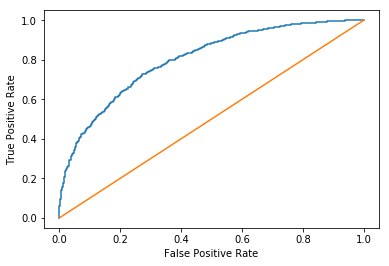

In [46]:
print 'Area under the curve: {0:.3f}'.format(roc_auc_score(y_dev2,  lrc1.predict(X_dev2)))

y_probas = lrc1.predict_proba(X_dev2)

fpr, tpr, thresholds = metrics.roc_curve(y_dev2.values, y_probas[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [47]:
# How to get a threshold and predictions based on a TPR

# index = np.where(tpr >= 0.8)
# threshold = thresholds[index[0][0]]
# predictions = (y_probas[:,1] > threshold).astype(int)

In [48]:
# Determine log-loss
print 'Log loss: {}'.format(log_loss(y_dev2.values, y_probas[:,1]))
# Determine RMSE
print 'RMSE: {}'.format(mean_squared_error(y_dev2.values, y_probas[:,1]))

Log loss: 0.546972362173
RMSE: 0.184853673199


Perform a Logistic Regression (Ridge) Using the **Regular Season**

In [49]:
lrc2 = LogisticRegression(penalty='l2')
params = {'C': [50,75,100,125,150,175,200,225]}
gscv2 = GridSearchCV(lrc2, params, scoring='accuracy', refit=True)
gscv2.fit(X_train2, y_train2)
print('Best accuracy: {:.4}, with best C: {}'.format(gscv2.best_score_, gscv2.best_params_['C']))

Best accuracy: 0.7103, with best C: 75


In [50]:
lrc2 = LogisticRegression(penalty='l2', C=gscv2.best_params_['C'])
lrc2.fit(X_train2, y_train2)
prediction2 = lrc2.predict(X_dev2)
print classification_report(prediction2, y_dev2)

             precision    recall  f1-score   support

          0       0.72      0.72      0.72       981
          1       0.72      0.72      0.72       981

avg / total       0.72      0.72      0.72      1962



Area under the curve: 0.720


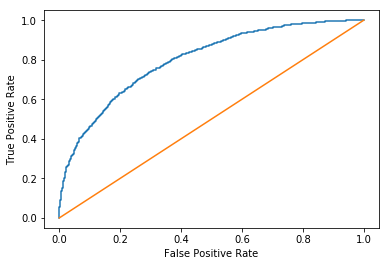

In [51]:
print 'Area under the curve: {0:.3f}'.format(roc_auc_score(y_dev2,  lrc2.predict(X_dev2)))

y_probas = lrc2.predict_proba(X_dev2)

fpr, tpr, thresholds = metrics.roc_curve(y_dev2.values, y_probas[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [52]:
# Determine log-loss
print 'Log loss: {}'.format(log_loss(y_dev2.values, y_probas[:,1]))
# Determine RMSE
print 'RMSE: {}'.format(mean_squared_error(y_dev2.values, y_probas[:,1]))

Log loss: 0.547656997109
RMSE: 0.185212816785


Perform a Logistic Regression (Lasso) Using **Combined Regular Season / Tournament Data**

In [53]:
lrc3 = LogisticRegression(penalty='l1')
params = {'C': [50,75,100,125,150,175,200,225]}
gscv3 = GridSearchCV(lrc3, params, scoring='accuracy', refit=True)
gscv3.fit(X_train2_combined, y_train2_combined)
print('Best accuracy: {:.4}, with best C: {}'.format(gscv3.best_score_, gscv3.best_params_['C']))

Best accuracy: 0.7104, with best C: 225


In [54]:
lrc3 = LogisticRegression(penalty='l1', C=gscv3.best_params_['C'])
lrc3.fit(X_train2_combined, y_train2_combined)
prediction3 = lrc3.predict(X_dev2_combined)
print classification_report(prediction3, y_dev2_combined)

             precision    recall  f1-score   support

          0       0.74      0.74      0.74       268
          1       0.74      0.74      0.74       268

avg / total       0.74      0.74      0.74       536



Area under the curve: 0.727


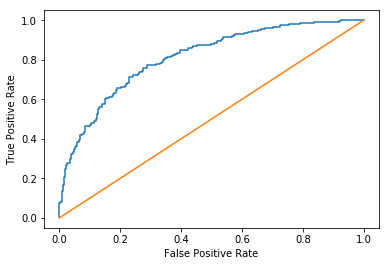

In [55]:
print 'Area under the curve: {0:.3f}'.format(roc_auc_score(y_dev2,  lrc3.predict(X_dev2)))

y_probas = lrc3.predict_proba(X_dev2_combined)

fpr, tpr, thresholds = metrics.roc_curve(y_dev2_combined.values, y_probas[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [56]:
# Determine log-loss
print 'Log loss: {}'.format(log_loss(y_dev2_combined.values, y_probas[:,1]))
# Determine RMSE
print 'RMSE: {}'.format(mean_squared_error(y_dev2_combined.values, y_probas[:,1]))

Log loss: 0.535985056604
RMSE: 0.180055449057


Perform a Logistic Regression (Ridge) Using **Combined Regular Season / Tournament Data**

In [57]:
lrc4 = LogisticRegression(penalty='l2')
params = {'C': [50,75,100,125,150,175,200,225]}
gscv4 = GridSearchCV(lrc4, params, scoring='accuracy', refit=True)
gscv4.fit(X_train2_combined, y_train2_combined)
print('Best accuracy: {:.4}, with best C: {}'.format(gscv4.best_score_, gscv4.best_params_['C']))

Best accuracy: 0.7105, with best C: 175


In [58]:
lrc4 = LogisticRegression(penalty='l2', C=gscv4.best_params_['C'])
lrc4.fit(X_train2_combined, y_train2_combined)
prediction4 = lrc4.predict(X_dev2_combined)
print classification_report(prediction4, y_dev2_combined)

             precision    recall  f1-score   support

          0       0.74      0.74      0.74       268
          1       0.74      0.74      0.74       268

avg / total       0.74      0.74      0.74       536



Area under the curve: 0.718


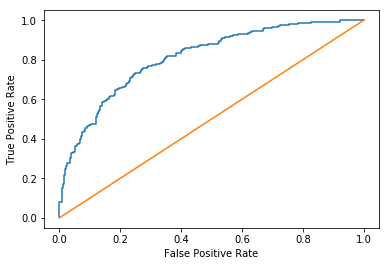

In [59]:
print 'Area under the curve: {0:.3f}'.format(roc_auc_score(y_dev2,  lrc4.predict(X_dev2)))

y_probas = lrc4.predict_proba(X_dev2_combined)

fpr, tpr, thresholds = metrics.roc_curve(y_dev2_combined.values, y_probas[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [60]:
# Determine log-loss
print 'Log loss: {}'.format(log_loss(y_dev2_combined.values, y_probas[:,1]))
# Determine RMSE
print 'RMSE: {}'.format(mean_squared_error(y_dev2_combined.values, y_probas[:,1]))

Log loss: 0.53613236783
RMSE: 0.180166789379


#### Look for the most influential features
https://stackoverflow.com/questions/34052115/how-to-find-the-importance-of-the-features-for-a-logistic-regression-model

#### Regular Season

In [61]:
importance_df = pd.DataFrame({
        'feature': reduced_features,
        'importance': np.abs(np.std(X_train2) * lrc1.coef_[0])
    })

importance_df.sort_values(by='importance', ascending=False)

,feature,importance
OpponentAvgRank,OpponentAvgRank,0.968346
AvgRank,AvgRank,0.968068
AvgNetPointsFor,AvgNetPointsFor,0.454190
OpponentAvgNetPointsFor,OpponentAvgNetPointsFor,0.447251
TourWinsDiff,TourWinsDiff,0.361983
WinPctDiff,WinPctDiff,0.303229
OpponentTourWins,OpponentTourWins,0.154933
TourWins,TourWins,0.154873
DefensiveRebounds_Opponent,DefensiveRebounds_Opponent,0.074365
DefensiveRebounds_Team,DefensiveRebounds_Team,0.073737


#### Combined Regular Season / Tournament

In [62]:
importance_df = pd.DataFrame({
        'feature': reduced_features,
        'importance': np.abs(np.std(X_train2_combined) * lrc3.coef_[0])
    })

importance_df.sort_values(by='importance', ascending=False)

,feature,importance
OpponentAvgRank,OpponentAvgRank,0.974258
AvgRank,AvgRank,0.974097
OpponentAvgNetPointsFor,OpponentAvgNetPointsFor,0.467286
AvgNetPointsFor,AvgNetPointsFor,0.446124
WinPctDiff,WinPctDiff,0.392764
TourWinsDiff,TourWinsDiff,0.243260
DefensiveRebounds_Opponent,DefensiveRebounds_Opponent,0.074400
DefensiveRebounds_Team,DefensiveRebounds_Team,0.074073
TwoPointPct_Team,TwoPointPct_Team,0.062966
TwoPointPct_Opponent,TwoPointPct_Opponent,0.062204


#### Tournament (2014-2017)

In [63]:
lrc5 = LogisticRegression(penalty='l1')
params = {'C': [50,75,100,125,150,175,200,225]}
gscv5 = GridSearchCV(lrc5, params, scoring='accuracy', refit=True)
gscv5.fit(X_dev2_combined, y_dev2_combined)
print('Best accuracy: {:.4}, with best C: {}'.format(gscv5.best_score_, gscv5.best_params_['C']))
lrc5 = LogisticRegression(penalty='l1', C=gscv5.best_params_['C'])
lrc5.fit(X_dev2_combined, y_dev2_combined)
importance_df = pd.DataFrame({
        'feature': reduced_features,
        'importance': np.abs(np.std(X_dev2_combined) * lrc5.coef_[0])
    })
importance_df.sort_values(by='importance', ascending=False)

Best accuracy: 0.7183, with best C: 50


,feature,importance
AvgRank,AvgRank,0.742925
OpponentAvgRank,OpponentAvgRank,0.742918
TourWinsDiff,TourWinsDiff,0.342199
AvgNetPointsFor,AvgNetPointsFor,0.333133
OpponentAvgNetPointsFor,OpponentAvgNetPointsFor,0.317146
OpponentTourWins,OpponentTourWins,0.273827
TourWins,TourWins,0.273816
WinPctDiff,WinPctDiff,0.167320
OpponentAvgPointsAgainst,OpponentAvgPointsAgainst,0.156840
AvgPointsAgainst,AvgPointsAgainst,0.139458
